In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import xgboost 
from sklearn import set_config
set_config(transform_output="pandas")
pd.set_option('display.max_columns', 500)

In [25]:
from db.database_mysql import engine

df = pd.read_sql_query('''SELECT jp.raw_title, 
        YEAR(jp.date) AS year, 
        MONTH(jp.date) AS month, 
        DAY(jp.date) AS day, 
        im.director, im.date,im.casting, im.distributor, im.genre, jp.country, jp.duration, jp.first_day, jp.first_week, jp.first_weekend, jp.hebdo_rank, 
jp.total_spectator, jp.copies, im.rating_press, im.budget, im.lang, im.award 
FROM films_jp as jp
LEFT JOIN films_imdb im ON im.id_jp = jp.id 
where im.id_jp is not null and im.date = jp.date
order by jp.first_week desc''', engine)

# CREATION DES SCORES

In [26]:
import json
from modelisation.functions import *

clone = df.copy()
calculate_director_scores(clone)
calculate_distributor_scores(clone)
calculate_actor_scores(clone)
calculate_year_scores(clone)
calculate_country_scores(clone)

# clone['genre'] = clone['genre'].apply(lambda x: json.loads(x)[0] if x is not None else x)
# clone
#print()

,raw_title,year,month,day,director,date,casting,distributor,genre,country,duration,first_day,first_week,first_weekend,hebdo_rank,total_spectator,copies,rating_press,budget,lang,award,distributor_list,actor_list,country_combined_score
0,Bienvenue chez les Ch'tis,2008,2,27,"""dany boon""",2008-02-27,"[""kad merad"", ""dany boon"", ""zoe felix""]","[""pathe renn productions"", ""hirsch"", ""les prod...","[""comedie"", ""romantique""]",france,6360,558359,4378720,3586497,1,20489303,793,7.1,11000000,"[""francais""]",5,"[""pathe renn productions"", ""hirsch"", ""les pr...","[""kad merad"", ""dany boon"", ""zoe felix""]",0.716108
1,Les Bronzés 3: Amis pour la vie,2006,2,1,"""patrice leconte""",2006-02-01,"[""josiane balasko"", ""michel blanc"", ""marieanne...","[""les films christian fechner"", ""tf1 films pro...","[""comedie""]",france,5820,537882,3906694,3235559,1,10355930,950,-1.0,35000000,"[""anglais"", ""italien"", ""francais""]",1,"[""les films christian fechner"", ""tf1 films pr...","[""josiane balasko"", ""michel blanc"", ""mariean...",0.716108
2,Taxi 2,2000,3,29,"""gerard krawczyk""",2000-03-29,"[""samy naceri"", ""frederic diefenthal"", ""emma w...","[""arp selection"", ""canal"", ""leeloo productions""]","[""action"", ""comedie"", ""policier""]",france,5400,801922,3478850,2951255,1,10345901,831,6.5,70000000,"[""francais"", ""japonais"", ""allemand""]",1,"[""arp selection"", ""canal"", ""leeloo productio...","[""samy naceri"", ""frederic diefenthal"", ""emma...",0.716108
3,La Revanche des Sith,2005,5,18,"""george lucas""",2005-05-18,"[""hayden christensen"", ""natalie portman"", ""ewa...","[""lucasfilm"", ""mestiere cinema"", ""pandora films""]","[""action"", ""aventure"", ""fantastique""]",etatsunis,8760,641799,3303005,2878764,1,7247809,938,7.6,113000000,"[""anglais""]",29,"[""lucasfilm"", ""mestiere cinema"", ""pandora fi...","[""hayden christensen"", ""natalie portman"", ""e...",0.918321
4,Le Roi Lion (2019),2019,7,17,"""jon favreau""",2019-07-17,"[""donald glover"", ""beyonce"", ""seth rogen""]","[""walt disney pictures"", ""fairview entertainme...","[""animation"", ""aventure"", ""drame""]",etatsunis,7080,630478,3252896,2559370,1,10017995,680,6.8,260000000,"[""anglais"", ""espagnol""]",21,"[""walt disney pictures"", ""fairview entertainm...","[""donald glover"", ""beyonce"", ""seth rogen""]",0.918321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,Simon Werner a disparu,2010,9,22,"""fabrice gobert""",2010-09-22,"[""jules pelissier"", ""ana girardot"", ""audrey ba...","[""247 films"", ""canal"", ""cinecinema""]",None,france,5580,6351,48033,40282,15,79945,93,6.4,-1,"[""francais""]",3,"[""247 films"", ""canal"", ""cinecinema""]","[""jules pelissier"", ""ana girardot"", ""audrey ...",0.716108
2669,Innocents The Dreamers,2003,12,10,"""bernardo bertolucci""",2003-12-10,"[""michael pitt"", ""louis garrel"", ""eva green""]","[""recorded picture company rpc"", ""fiction"", ""p...",None,france,6960,7577,47922,-1,13,79849,-1,7.1,15000000,"[""anglais"", ""francais""]",2,"[""recorded picture company rpc"", ""fiction"", ...","[""michael pitt"", ""louis garrel"", ""eva green""]",0.716108
2670,La Grande Bellezza,2013,5,22,"""paolo sorrentino""",2013-05-22,"[""toni servillo"", ""carlo verdone"", ""sabrina fe...","[""indigo film"", ""medusa film"", ""babe film""]","[""drame""]",italie,8460,4654,47900,36844,13,198373,81,7.7,9200000,"[""italien"", ""japonais"", ""espagnol"", ""chinois""]",60,"[""indigo film"", ""medusa film"", ""babe film""]","[""toni servillo"", ""carlo verdone"", ""sabrina ...",0.338789
2671,Un baiser papillon,2011,6,1,"""karine silla""",2011-06-01,"[""valeria golino"", ""elsa zylberstein"", ""vincen...","[""europacorp"", ""grive productions"", ""france 2 ...",None,france,6060,-1,47715,38189,14,47715,170,5.4,3500000,"[""francais""]",2,"[""europacorp"", ""grive productions"", ""france ...","[""valeria golino"", ""elsa zylberstein"", ""vinc...",0.716108


In [27]:
from modelisation.functions import *

entree_transformer = FunctionTransformer(classify_entrees_year, kw_args={'column' : 'year'})
season_transformer = FunctionTransformer(classify_season,  kw_args={'column' : 'month'})
month_transformer = FunctionTransformer(classify_month_name,  kw_args={'column' : 'month'})
holiday_transformer = FunctionTransformer(is_holiday)

pipe_scores = Pipeline([
  ('season_dict' , make_pipeline(season_transformer)),
  ('entree_dict' , make_pipeline(entree_transformer)),
  ('month_dict' , make_pipeline(month_transformer)),
  ('holiday_dict' , make_pipeline(holiday_transformer)),
])

# scores = df.copy()
# scores = pipe_scores.fit_transform(scores)
# scores.head(1)

# MODELE

In [28]:
# film = pd.read_sql_query('''SELECT 
#                               YEAR(date) AS year, 
#                               MONTH(date) AS month, 
#                               DAY(date) AS day, 
#                               director, distributor, casting, copies, duration, country
#                             FROM functionalities_filmscrap
#                             LIMIT 1
#                          ''', engine)
# film

In [29]:
from modelisation.converter import *

entree_converter = FunctionTransformer(convert_entrees_year, kw_args={'column' : 'year'})
country_converter = FunctionTransformer(convert_country, kw_args={'column' : 'country'})
season_converter = FunctionTransformer(classify_season,  kw_args={'column' : 'month'})
month_converter = FunctionTransformer(classify_month_name,  kw_args={'column' : 'month'})
holiday_converter = FunctionTransformer(is_holiday)
director_converter = FunctionTransformer(convert_director, kw_args={'column' : 'director'})
actor_converter = FunctionTransformer(convert_actor, kw_args={'column' : 'casting'})
distributor_converter = FunctionTransformer(convert_distributor, kw_args={'column' : 'distributor'})
clean_genre_transformer = FunctionTransformer(clean_genre)

drop_after_converter_pipeline = Pipeline([
  ('drop_after_converter', make_pipeline(FunctionTransformer(drop_after_converter)))
])

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int)
ohe_transformer = ColumnTransformer(
    transformers=[
        ('categorical', ohe, ['season', 'month_name', 'genre'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipe = Pipeline([
  ('clean_genre_transformer', make_pipeline(clean_genre_transformer)),
  ('actor_converter' , make_pipeline(actor_converter)),
  ('entree_converter' , make_pipeline(entree_converter)),
  ('season_converter' , make_pipeline(season_converter)),
  ('country_converter' , make_pipeline(country_converter)),
  ('month_converter' , make_pipeline(month_converter)),
  ('holiday_converter' , make_pipeline(holiday_converter)),
  ('director_converter' , make_pipeline(director_converter)),
  ('distributor_converter' , make_pipeline(distributor_converter)),
])


# t = df.copy()
# p = pipe.fit_transform(t)
# p
# t.drop(columns=['raw_title', 'date', 'genre', 'budget', 'total_spectator', 'first_day', 'first_weekend', 'hebdo_rank', 'total_spectator', 'rating_press', 'award', 'lang'], inplace=True)
# p = pipe.fit_transform(t)
# p[p.isna().any(axis=1)]


# Pipe de conversion des data

In [30]:
df_clean = df.copy()
df_clean.drop(columns=['raw_title', 'date', 'budget', 'total_spectator', 'first_day', 'first_weekend', 'hebdo_rank', 'total_spectator', 'rating_press', 'award', 'lang'], inplace=True)

X = df_clean.drop(columns=['first_week'])

pipe_transform = make_pipeline(pipe)
transformed_data = pipe_transform.transform(X)

convert_actor
convert_entrees_year 2008
convert_country france
convert_director
convert_distributor


In [60]:
from sklearn.discriminant_analysis import StandardScaler


y = df_clean.first_week

t = transformed_data.copy()
t.drop(columns=['copies'], inplace=True)
#display(df)
X_train, X_test, y_train, y_test = train_test_split(t, y, shuffle=True, train_size=0.85, random_state=42)

model = make_pipeline(
  drop_after_converter_pipeline,
  ohe_transformer,
  #PolynomialFeatures(2),
  RobustScaler(with_centering=True),
  #StandardScaler(),
  xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
)

model.fit(X_train, y_train)
print()
# m = model.fit_transform(X_train)
# m

Performance du modèle :
R2 Score: 0.3642
MAE: 187921.27
RMSE: 311644.45


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

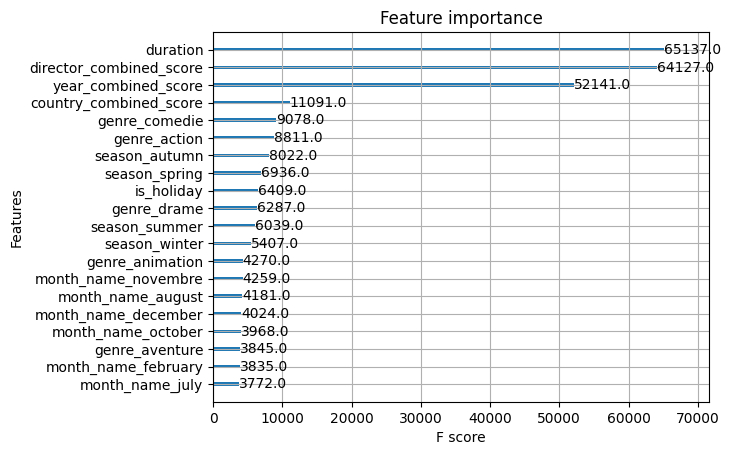

In [59]:
y_pred = model.predict(X_test)

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

xgboost.plot_importance(model[-1], max_num_features=20)

In [61]:
leroy = pd.DataFrame({
    'year': [2024],
    'day': [10],
    'month': [4],
    'duration': [6120],
    'country': ['france'],
    'copies': [414],
    'genre': [['comedie']],
    'director': ['"florent bernard"'],
    'distributor': [["nolita cinema", "tf1 studio", "apollo films"]],
    'casting': [["charlotte gainsbourg", "jose garcia", "lily aubry"]],
})


transformed = pipe_transform.transform(leroy)
display(transformed)
model.predict(transformed)

convert_actor
convert_entrees_year 2024
convert_country france
convert_director
convert_distributor


,year,day,month,duration,country,copies,genre,director,distributor,casting,actor_combined_score,year_combined_score,season,country_combined_score,month_name,is_holiday,director_combined_score,distributor_combined_score
0,2024,10,4,6120,france,414,comedie,"""florent bernard""","[nolita cinema, tf1 studio, apollo films]","[charlotte gainsbourg, jose garcia, lily aubry]",0.656811,0.440816,spring,0.716108,april,0,0.1,0.402027


array([37413.727], dtype=float32)

In [34]:
from joblib import dump

dump(pipe_transform, './pipe_transform.pkl')
dump(model, './model.pkl')

['./model.pkl']